In [ ]:
#export 
from local.test import *
from local.basics import *
from local.vision.core import *
from local.vision.data import *
from local.vision.augment import *
from local.vision import models

In [ ]:
#default_exp vision.learner

In [ ]:
from local.notebook.showdoc import *

# Learner for the vision applications

> All the functions necessary to build `Learner` suitable for transfer learning in computer vision

## Cut a pretrained model

In [ ]:
# export
def _is_pool_type(l): return re.search(r'Pool[123]d$', l.__class__.__name__)

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
test_eq([bool(_is_pool_type(m_)) for m_ in m.children()], [True,False,False,True])

In [ ]:
# export
def has_pool_type(m):
    "Return `True` if `m` is a pooling layer or has one in its children"
    if _is_pool_type(m): return True
    for l in m.children():
        if has_pool_type(l): return True
    return False

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
assert has_pool_type(m)
test_eq([has_pool_type(m_) for m_ in m.children()], [True,False,False,True])

In [ ]:
#export
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

`cut` can either be an integer, in which case we cut the model at the coresponding layer, or a function, in which case, this funciton returns `cut(model)`. It defaults to `cnn_config(arch)['cut']` if `arch` is in `cnn_config`, otherwise to the first layer that contains some pooling.

In [ ]:
tst = lambda pretrained : nn.Sequential(nn.Conv2d(4,5,3), nn.BatchNorm2d(5), nn.AvgPool2d(1), nn.Linear(3,4))
m = create_body(tst)
test_eq(len(m), 2)

m = create_body(tst, cut=3)
test_eq(len(m), 3)

m = create_body(tst, cut=noop)
test_eq(len(m), 4)

## Head and model

In [ ]:
#export
def create_head(nf, nc, lin_ftrs=None, ps=0.5, concat_pool=True, bn_final=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `nc` classes."
    lin_ftrs = [nf, 512] if lin_ftrs is None else [nf] + lin_ftrs
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-1) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-1) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn)
    layers.append(nn.Linear(lin_ftrs[-1], nc))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

In [ ]:
tst = create_head(5, 10)
tst

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=5, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
#export
from local.callback.hook import num_features_model

In [ ]:
#export
def create_cnn_model(arch, nc, cut, pretrained, lin_ftrs=None, ps=0.5, custom_head=None,
                     bn_final=False, concat_pool=True, init=nn.init.kaiming_normal_):
    "Create custom convnet architecture using `base_arch`"
    body = create_body(arch, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, nc, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [ ]:
tst = create_cnn_model(models.resnet18, 10, None, True)

In [ ]:
#export
@delegates(create_cnn_model)
def cnn_config(**kwargs):
    "Convenienc function to easily create a config for `create_cnn_model`"
    return kwargs

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dbunch = pets.databunch(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        batch_tfms=[*aug_transforms(size=224), Normalize(*imagenet_stats)])

In [ ]:
#TODO: refactor, i.e. something like this?
# class ModelSplitter():
#     def __init__(self, idx): self.idx = idx
#     def split(self, m): return L(m[:self.idx], m[self.idx:]).map(params)
#     def __call__(self,): return {'cut':self.idx, 'split':self.split}

In [ ]:
#export
def default_split(m:nn.Module): return L(m[0], m[1:]).map(params)

In [ ]:
#export
def _xresnet_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
def _squeezenet_split(m:nn.Module): return L(m[0][0][:5], m[0][0][5:], m[1:]).map(params)
def _densenet_split(m:nn.Module): return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)
def _vgg_split(m:nn.Module): return L(m[0][0][:22], m[0][0][22:], m[1:]).map(params)
def _alexnet_split(m:nn.Module): return L(m[0][0][:6], m[0][0][6:], m[1:]).map(params)

_default_meta    = {'cut':None, 'split':default_split}
_xresnet_meta    = {'cut':-3, 'split':_xresnet_split }
_resnet_meta     = {'cut':-2, 'split':_resnet_split }
_squeezenet_meta = {'cut':-1, 'split': _squeezenet_split}
_densenet_meta   = {'cut':-1, 'split':_densenet_split}
_vgg_meta        = {'cut':-2, 'split':_vgg_split}
_alexnet_meta    = {'cut':-2, 'split':_alexnet_split}

In [ ]:
#export
model_meta = {
    models.xresnet.xresnet18 :{**_xresnet_meta}, models.xresnet.xresnet34: {**_xresnet_meta},
    models.xresnet.xresnet50 :{**_xresnet_meta}, models.xresnet.xresnet101:{**_xresnet_meta},
    models.xresnet.xresnet152:{**_xresnet_meta},
    
    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},

    models.squeezenet1_0:{**_squeezenet_meta},
    models.squeezenet1_1:{**_squeezenet_meta},

    models.densenet121:{**_densenet_meta}, models.densenet169:{**_densenet_meta},
    models.densenet201:{**_densenet_meta}, models.densenet161:{**_densenet_meta},
    models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},
    models.alexnet:{**_alexnet_meta}}

## `Learner` convenience functions

In [ ]:
#export
@delegates(Learner.__init__)
def cnn_learner(dbunch, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, **kwargs):
    "Build a convnet style learner"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    model = create_cnn_model(arch, get_c(dbunch), ifnone(cut, meta['cut']), pretrained, **config)
    learn = Learner(dbunch, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

The model is built from `arch` using the number of final activation inferred from `dbunch` by `get_c`. It might be `pretrained` and the architecture is cut and split using the default metadata of the model architecture (this can be customized by passing a `cut` or a `splitter`). To customize the model creation, use `cnn_config` and pass the result to the `config` argument.

In [ ]:
learn = cnn_learner(dbunch, models.resnet34, loss_func=CrossEntropyLossFlat(), config=cnn_config(ps=0.25))

In [ ]:
#export
@delegates(models.unet.DynamicUnet.__init__)
def unet_config(**kwargs):
    "Convenience function to easily create a config for `DynamicUnet`"
    return kwargs

In [ ]:
#export
@delegates(Learner.__init__)
def unet_learner(dbunch, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, **kwargs):
    "Build a unet learner from `dbunch` and `arch`"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, pretrained, ifnone(cut, meta['cut']))
    try:    size = dbunch.train_ds[0][0].size
    except: size = dbunch.one_batch()[0].shape[-2:]
    model = models.unet.DynamicUnet(body, get_c(dbunch), size, **config)
    learn = Learner(dbunch, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

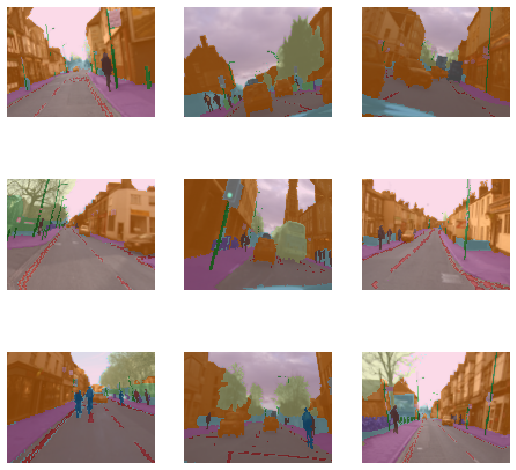

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(untar_data(URLs.CAMVID_TINY)/"images", batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
#TODO: Find a way to pass the classes properly
dbunch.vocab = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)

In [ ]:
learn = unet_learner(dbunch, models.resnet34, loss_func=CrossEntropyLossFlat(axis=1), config=unet_config())

## Show functions

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y, samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_results[object](x, y, samples, outs, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:TensorCategory, samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i in range(2):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    ctxs = [r.show(ctx=c, color='green' if b==r else 'red', **kwargs)
            for b,r,c,_ in zip(samples.itemgot(1),outs.itemgot(0),ctxs,range(max_n))]
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:(TensorImageBase, TensorPoint, TensorBBox), samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize, double=True)
    for i in range(2):
        ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[::2],range(max_n))]
    for x in [samples,outs]:
        ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(x.itemgot(0),ctxs[1::2],range(max_n))]
    return ctxs

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
        s[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorMultiCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i,(ax,s) in enumerate(zip(axs, samples)): s[0].show(ctx=ax, title=f'Image {i}', **kwargs)
    rows = get_empty_df(len(samples))
    outs = L(s[1:] + o + (Str(r), Float(l.item())) for s,o,r,l in zip(samples, outs, raws, losses))
    for i,l in enumerate(["target", "predicted", "probabilities", "loss"]):
        rows = [b.show(ctx=r, label=l, **kwargs) for b,r in zip(outs.itemgot(i),rows)]
    display_df(pd.DataFrame(rows))

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core_foundation.ipynb.
Converted 01a_core_utils.ipynb.
Converted 01b_core_dispatch.ipynb.
Converted 01c_core_transform.ipynb.
Converted 02_core_script.ipynb.
Converted 03_torchcore.ipynb.
Converted 03a_layers.ipynb.
Converted 04_data_load.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 09a_vision_data.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Co